# ROB 498: Robot Learning for Planning and Control
# Assignment 6: Reinforcement Learning

## Colab Setup

In [1]:
# TODO: Fill in the Google Drive path where you uploaded the assignment
# Example: If you create a ROB498 folder and put all the files under HW4 folder, then 'ROB498/HW4'
GOOGLE_DRIVE_PATH_AFTER_MYDRIVE = 'ROB498/HW6'

### Setup Code 

In [68]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
from google.colab import drive

drive.mount('/content/drive')

In [ ]:
import os
import sys

GOOGLE_DRIVE_PATH = os.path.join('drive', 'My Drive', GOOGLE_DRIVE_PATH_AFTER_MYDRIVE)

files = os.listdir(GOOGLE_DRIVE_PATH)
expected_files = [ 'ROB498_hw6.ipynb', 'panda_pushing_env.py', 'visualizers.py', 'pushing_rl.py']

sys.path.append(GOOGLE_DRIVE_PATH)

# Verify that there are all the expected files in the directory
all_found = True
for expected_file in expected_files:
  if expected_file not in files:
    print(f'Required file {expected_file} not found!')
    all_found = False
if all_found:
  print('All required files are found :)')

In [2]:
# Install missing required packages 
# Unfortunately Colab does not have pybullet package by default, so we will have to install it every time that the notebook kernel is restarted.
# Install pybullet -- For simulation purposes
!pip install pybullet
# Install numpngw -- For visualization purposes
!pip install numpngw
# Install stable-baselines -- For RL implementations
!pip install stable-baselines3[extra]

zsh:1: no matches found: stable-baselines3[extra]


In [3]:
!pip install "stable-baselines3[extra]"

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 15.8 MB/s eta 0:00:00 MB/s eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 958.1/958.1 kB 42.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 50.2 MB/s eta 0:00:00m eta 0:00:010:0101
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 20.7 MB/s eta 0:00:00


In [52]:
import torch
import os
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from numpngw import write_apng
from IPython.display import Image
from tqdm.notebook import tqdm

from stable_baselines3 import PPO
from stable_baselines3.common.env_util import make_vec_env

# Reinforcement Learning for Planar Pushing (100 points)

We will be applying model-free reinforcement learning to the planar block pushing task that you have seen in homeworks 3 and 5. 

Rather than implement your own RL algorithms, in this homework you will use [Stable-Baselines3](https://stable-baselines3.readthedocs.io/en/master/). Stable-Baselines3 has implementations of a variety of different RL algorithms for you to use, and it is recommended that use these implementations rather than implement the RL algorithms yourself.

For this homework you will use PPO to learn a policy for the block planar pushing task. For more details about the PPO implementation, check out the [stable-baselines3](https://stable-baselines3.readthedocs.io/en/master/modules/ppo.html) page.


# 1 - PPO on Object Pose Space:

In [55]:
from panda_pushing_env import PandaPushingEnv, TARGET_POSE, OBSTACLE_CENTRE, OBSTACLE_HALFDIMS, BOX_SIZE
from visualizers import GIFVisualizer, NotebookVisualizer



## 1.1 - Obstacle Free Pushing
In this section you will implement a reward function for the RL algorithm for the case where there are no obstacles on the table. The reward function you choose is completely up to you. We will only evaluate the resulting policy on task performance. 

Some tips for your reward function
- In general dense rewards perform better than sparse rewards. A sparse reward is a reward that gives sparse signals, for example, a high reward for successfully completing the task. A dense reward gives signals at every timestep of the episode, for example, the distance to goal. 
- It is a good idea to combine a dense reward such as distance to goal with a large reward for task completion
- You may want to give a negative reward for task failure, such as the block leaving the allowable region. 

You should upload the trained policy to autograder. The autograder will run the policy 10 times and will pause if the policy succeeds once.

**TODO**:
* From `pushing_rl.py` edit the `obstacle_free_pushing_reward_function_object_pose_space`. The goal pose is `TARGET_POSE` which is a global variable
* From `pushing_rl.py` complete the `execute_policy`. We will use this for rolling out trajectories using the learned policy. 

In [87]:
!pip install 'shimmy>=2.0'

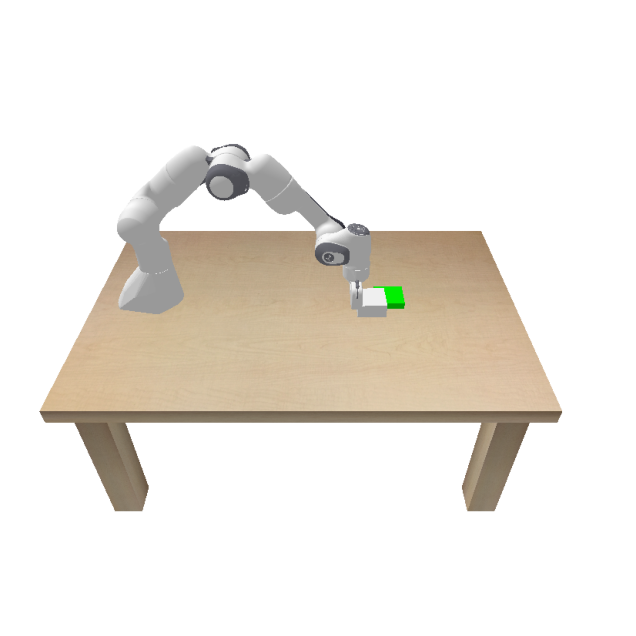

argv[0]=--opengl2
Step 0: Executing action...
Step 1: Executing action...
Step 2: Executing action...
Step 3: Executing action...
Step 4: Executing action...
Step 5: Executing action...
Step 6: Executing action...
Step 7: Executing action...
Step 8: Executing action...
Step 9: Executing action...
Step 10: Executing action...
Step 11: Executing action...
Step 12: Executing action...
Step 13: Executing action...
Step 14: Executing action...
Step 14: Goal Reached!
GOAL REACHED: True
State [ 0.40161845 -0.00118362 -0.6255525 ] has a reward -0.8489233236897324
State [ 0.41796133 -0.01000411 -0.40185156] has a reward 0.2799646820623609
State [ 0.4214071  -0.01136463 -0.3865773 ] has a reward -0.48661464535185117
State [ 0.43023908 -0.0128865  -0.48142475] has a reward -1.1076306832759553
State [ 0.44557157 -0.01899174 -0.29287645] has a reward 0.13677876775812953
State [ 0.5152238  -0.02199346  0.02062432] has a reward 0.47073262466474386
State [ 0.5153286  -0.02198082  0.02061785] has a rew

In [108]:
%reload_ext autoreload
%matplotlib inline
from pushing_rl import *

# Create the visualizer
fig = plt.figure(figsize=(8,8))
hfig = display(fig, display_id=True)
visualizer = NotebookVisualizer(fig=fig, hfig=hfig)

# Initialize the simulation environment having 'object_pose' as state space.
env = PandaPushingEnv(state_space='object_pose', 
                                reward_function=obstacle_free_pushing_reward_function_object_pose_space, 
                                visualizer=visualizer, 
                                render_non_push_motions=False,  
                                render_every_n_steps=3,
                                camera_heigh=800, 
                                camera_width=800)
env.reset()



# Perform a sequence of 3 random actions:
random_policy = RandomPolicy(env)

states, rewards, goal_reached = execute_policy(env, random_policy, num_steps=20)

plt.close(fig)
print(f'GOAL REACHED: {goal_reached}')
for state_i, reward_i in zip(states[1:], rewards):
    print(f'State {state_i} has a reward {reward_i}')

### Apply Stable Baselines:

In [113]:
total_timesteps = 25000 # You may need to play with this number

env = PandaPushingEnv(state_space='object_pose',
                                reward_function=obstacle_free_pushing_reward_function_object_pose_space)
env.reset()
model = PPO("MlpPolicy", env, verbose=1)
model.learn(total_timesteps=total_timesteps, progress_bar=True)
model.save("free_pushing_object_pose")

Output()

argv[0]=--opengl2
Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 24       |
|    ep_rew_mean     | -17.1    |
| time/              |          |
|    fps             | 4        |
|    iterations      | 1        |
|    time_elapsed    | 416      |
|    total_timesteps | 2048     |
---------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 22.1        |
|    ep_rew_mean          | -14.2       |
| time/                   |             |
|    fps                  | 4           |
|    iterations           | 2           |
|    time_elapsed         | 839         |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.011824844 |
|    clip_fraction        | 0.123       |
|    clip_range           | 0.2         |
|    entropy_loss         | -4.24       |
|    explained_variance   | -0.0206     |
|    learning_rate        | 0.0003      |
|    loss                 | 14          |
|    n_updates            | 10          |
|    policy_gradient_loss | -0.0105     |
|    std                  | 0.986       |
|    value_loss           | 35.5        |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 21.1        |
|    ep_rew_mean          | -12.9       |
| time/                   |             |
|    fps                  | 4           |
|    iterations           | 3           |
|    time_elapsed         | 1263        |
|    total_timesteps      | 6144        |
| train/                  |             |
|    approx_kl            | 0.009278022 |
|    clip_fraction        | 0.112       |
|    clip_range           | 0.2         |
|    entropy_loss         | -4.19       |
|    explained_variance   | 0.211       |
|    learning_rate        | 0.0003      |
|    loss                 | 16.8        |
|    n_updates            | 20          |
|    policy_gradient_loss | -0.0113     |
|    std                  | 0.97        |
|    value_loss           | 36.6        |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 21.4        |
|    ep_rew_mean          | -11.7       |
| time/                   |             |
|    fps                  | 4           |
|    iterations           | 4           |
|    time_elapsed         | 1700        |
|    total_timesteps      | 8192        |
| train/                  |             |
|    approx_kl            | 0.006945105 |
|    clip_fraction        | 0.101       |
|    clip_range           | 0.2         |
|    entropy_loss         | -4.12       |
|    explained_variance   | 0.317       |
|    learning_rate        | 0.0003      |
|    loss                 | 9.65        |
|    n_updates            | 30          |
|    policy_gradient_loss | -0.0146     |
|    std                  | 0.945       |
|    value_loss           | 28.1        |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 21.4        |
|    ep_rew_mean          | -11.7       |
| time/                   |             |
|    fps                  | 4           |
|    iterations           | 5           |
|    time_elapsed         | 2274        |
|    total_timesteps      | 10240       |
| train/                  |             |
|    approx_kl            | 0.009876481 |
|    clip_fraction        | 0.107       |
|    clip_range           | 0.2         |
|    entropy_loss         | -4.05       |
|    explained_variance   | 0.0776      |
|    learning_rate        | 0.0003      |
|    loss                 | 17.1        |
|    n_updates            | 40          |
|    policy_gradient_loss | -0.0141     |
|    std                  | 0.926       |
|    value_loss           | 30          |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 21.4        |
|    ep_rew_mean          | -11.7       |
| time/                   |             |
|    fps                  | 4           |
|    iterations           | 6           |
|    time_elapsed         | 2848        |
|    total_timesteps      | 12288       |
| train/                  |             |
|    approx_kl            | 0.015339061 |
|    clip_fraction        | 0.0845      |
|    clip_range           | 0.2         |
|    entropy_loss         | -3.98       |
|    explained_variance   | -0.00122    |
|    learning_rate        | 0.0003      |
|    loss                 | 0.401       |
|    n_updates            | 50          |
|    policy_gradient_loss | -0.00719    |
|    std                  | 0.879       |
|    value_loss           | 14.1        |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 21.4        |
|    ep_rew_mean          | -11.7       |
| time/                   |             |
|    fps                  | 4           |
|    iterations           | 7           |
|    time_elapsed         | 3410        |
|    total_timesteps      | 14336       |
| train/                  |             |
|    approx_kl            | 0.008022722 |
|    clip_fraction        | 0.0307      |
|    clip_range           | 0.2         |
|    entropy_loss         | -3.85       |
|    explained_variance   | -1.73e-05   |
|    learning_rate        | 0.0003      |
|    loss                 | -0.0304     |
|    n_updates            | 60          |
|    policy_gradient_loss | -0.00424    |
|    std                  | 0.86        |
|    value_loss           | 14.8        |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 21.4        |
|    ep_rew_mean          | -11.7       |
| time/                   |             |
|    fps                  | 4           |
|    iterations           | 8           |
|    time_elapsed         | 3956        |
|    total_timesteps      | 16384       |
| train/                  |             |
|    approx_kl            | 0.009358117 |
|    clip_fraction        | 0.038       |
|    clip_range           | 0.2         |
|    entropy_loss         | -3.78       |
|    explained_variance   | 0           |
|    learning_rate        | 0.0003      |
|    loss                 | 0.308       |
|    n_updates            | 70          |
|    policy_gradient_loss | -0.00538    |
|    std                  | 0.839       |
|    value_loss           | 10.8        |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 21.4        |
|    ep_rew_mean          | -11.7       |
| time/                   |             |
|    fps                  | 4           |
|    iterations           | 9           |
|    time_elapsed         | 4493        |
|    total_timesteps      | 18432       |
| train/                  |             |
|    approx_kl            | 0.010860005 |
|    clip_fraction        | 0.0324      |
|    clip_range           | 0.2         |
|    entropy_loss         | -3.69       |
|    explained_variance   | -1.92e-05   |
|    learning_rate        | 0.0003      |
|    loss                 | -0.0406     |
|    n_updates            | 80          |
|    policy_gradient_loss | -0.0053     |
|    std                  | 0.803       |
|    value_loss           | 6.74        |
-----------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 21.4         |
|    ep_rew_mean          | -11.7        |
| time/                   |              |
|    fps                  | 4            |
|    iterations           | 10           |
|    time_elapsed         | 5028         |
|    total_timesteps      | 20480        |
| train/                  |              |
|    approx_kl            | 0.0117222015 |
|    clip_fraction        | 0.0747       |
|    clip_range           | 0.2          |
|    entropy_loss         | -3.55        |
|    explained_variance   | 1.19e-07     |
|    learning_rate        | 0.0003       |
|    loss                 | -0.0192      |
|    n_updates            | 90           |
|    policy_gradient_loss | -0.0116      |
|    std                  | 0.773        |
|    value_loss           | 3.79         |
------------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 21.4      |
|    ep_rew_mean          | -11.7     |
| time/                   |           |
|    fps                  | 4         |
|    iterations           | 11        |
|    time_elapsed         | 5554      |
|    total_timesteps      | 22528     |
| train/                  |           |
|    approx_kl            | 0.0143154 |
|    clip_fraction        | 0.0677    |
|    clip_range           | 0.2       |
|    entropy_loss         | -3.43     |
|    explained_variance   | -1.19e-07 |
|    learning_rate        | 0.0003    |
|    loss                 | 0.0949    |
|    n_updates            | 100       |
|    policy_gradient_loss | -0.0107   |
|    std                  | 0.736     |
|    value_loss           | 2.24      |
---------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 21.4        |
|    ep_rew_mean          | -11.7       |
| time/                   |             |
|    fps                  | 4           |
|    iterations           | 12          |
|    time_elapsed         | 6070        |
|    total_timesteps      | 24576       |
| train/                  |             |
|    approx_kl            | 0.013768595 |
|    clip_fraction        | 0.0813      |
|    clip_range           | 0.2         |
|    entropy_loss         | -3.26       |
|    explained_variance   | 2.38e-07    |
|    learning_rate        | 0.0003      |
|    loss                 | -0.0326     |
|    n_updates            | 110         |
|    policy_gradient_loss | -0.0129     |
|    std                  | 0.699       |
|    value_loss           | 1.16        |
-----------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 21.4         |
|    ep_rew_mean          | -11.7        |
| time/                   |              |
|    fps                  | 4            |
|    iterations           | 13           |
|    time_elapsed         | 6579         |
|    total_timesteps      | 26624        |
| train/                  |              |
|    approx_kl            | 0.0142462915 |
|    clip_fraction        | 0.0723       |
|    clip_range           | 0.2          |
|    entropy_loss         | -3.09        |
|    explained_variance   | -1.19e-07    |
|    learning_rate        | 0.0003       |
|    loss                 | -0.0223      |
|    n_updates            | 120          |
|    policy_gradient_loss | -0.0138      |
|    std                  | 0.661        |
|    value_loss           | 0.604        |
------------------------------------------


Visualize the learned policy performance:

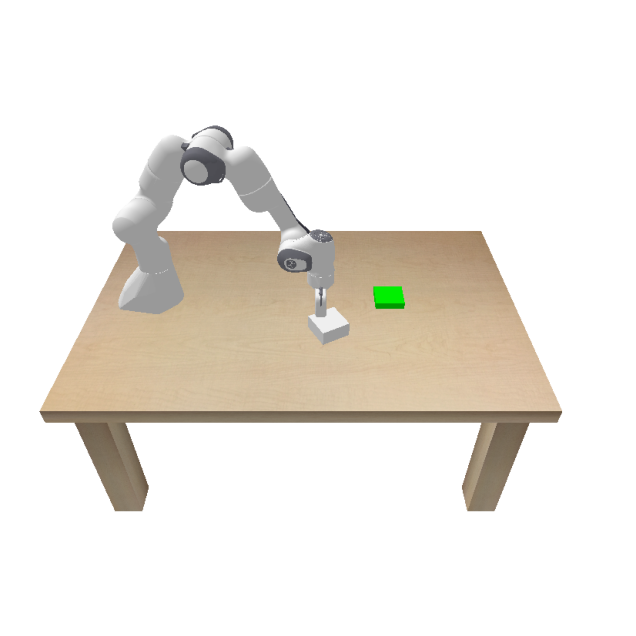

argv[0]=--opengl2
Step 0: Executing action...
Step 1: Executing action...
Step 2: Executing action...
Step 3: Executing action...
Step 4: Executing action...
Step 5: Executing action...
Step 6: Executing action...
Step 7: Executing action...
Step 8: Executing action...
Step 9: Executing action...
Step 10: Executing action...
Step 11: Executing action...
Step 12: Executing action...
Step 13: Executing action...
Step 14: Executing action...
Step 15: Executing action...
Step 16: Executing action...
Step 17: Executing action...
Step 18: Executing action...
Step 19: Executing action...
Step 19: Environment done. Resetting...
Step 20: Executing action...
Step 21: Executing action...
Step 22: Executing action...
Step 23: Executing action...
Step 24: Executing action...
Step 25: Executing action...
Step 26: Executing action...
Step 27: Executing action...
Step 28: Executing action...
Step 29: Executing action...
Step 30: Executing action...
Step 31: Executing action...
Step 32: Executing actio

In [137]:
%matplotlib inline
model = PPO.load("free_pushing_object_pose")
# Create the visualizer
fig = plt.figure(figsize=(8,8))
hfig = display(fig, display_id=True)
visualizer = NotebookVisualizer(fig=fig, hfig=hfig)
env = PandaPushingEnv(state_space='object_pose', 
                                reward_function=obstacle_free_pushing_reward_function_object_pose_space, 
                                visualizer=visualizer, 
                                render_non_push_motions=False,  
                                camera_heigh=800, 
                                camera_width=800)
num_steps = 40

states, rewards, goal_reached = execute_policy(env, model, num_steps)
        
print(f'GOAL REACHED: {goal_reached}')

plt.close(fig)

## 1.2 - Pushing with Obstacles
In this section you will implement a reward function for the RL algorithm for the case where there is an obstacle on the table. The position and dimensions of the obstacle is given as global variables `OBSTACLE_CENTRE` and `OBSTACLE_HALFDIMS`. As before, the reward function you choose is completely up to you. We will only evaluate the resulting policy on task performance. 

While you may be able to use the same reward function as the obstacle-free case to successfully learn a policy, you may find that incorporating a collision check into the reward can lead to faster learning. 

You should upload the trained policy to autograder. The autograder will run the policy 10 times and will pause if the policy succeeds once.

**TODO**:
* From `pushing_rl.py` edit the `pushing_with_obstacles_reward_function_object_pose_space`. The goal pose is `TARGET_POSE` which is a global variable

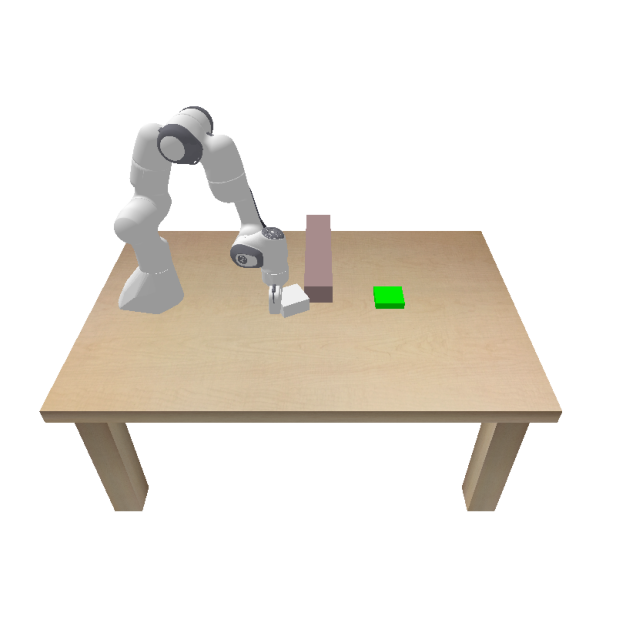

argv[0]=--opengl2
Step 0: Executing action...
Step 1: Executing action...
Step 2: Executing action...
GOAL REACHED: False
State [ 0.43166107 -0.00261542 -0.29863915] has a reward -0.6026575571069867
State [ 0.439201   -0.00687455 -0.24984413] has a reward -0.40781928039595217
State [ 0.45264518 -0.01728514  0.47948396] has a reward -1.4832244291341816


In [115]:
# visualize the obstacle env
%reload_ext autoreload
%matplotlib inline

# Create the visualizer
fig = plt.figure(figsize=(8,8))
hfig = display(fig, display_id=True)
visualizer = NotebookVisualizer(fig=fig, hfig=hfig)

# Initialize the simulation environment having 'object_pose' as state space.
env = PandaPushingEnv(state_space='object_pose', 
                                reward_function=pushing_with_obstacles_reward_function_object_pose_space,
                                include_obstacle=True,
                                visualizer=visualizer, 
                                render_non_push_motions=False,
                                render_every_n_steps=5,
                                camera_heigh=800, 
                                camera_width=800)
env.reset()



# Perform a sequence of 3 random actions:
random_policy = RandomPolicy(env)

states, rewards, goal_reached = execute_policy(env, random_policy, num_steps=3)

plt.close(fig)
print(f'GOAL REACHED: {goal_reached}')
for state_i, reward_i in zip(states[1:], rewards):
    print(f'State {state_i} has a reward {reward_i}')


In [116]:
total_timesteps = 50000 # You may need to play with this number

env = PandaPushingEnv(state_space='object_pose',
                                reward_function=pushing_with_obstacles_reward_function_object_pose_space, include_obstacle=True)
env.reset()
obstacle_policy_model = PPO("MlpPolicy", env, verbose=1)
obstacle_policy_model.learn(total_timesteps=total_timesteps, progress_bar=True)
obstacle_policy_model.save("obstacle_pushing_object_pose")

Output()

argv[0]=--opengl2
Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 23.9     |
|    ep_rew_mean     | -20.6    |
| time/              |          |
|    fps             | 4        |
|    iterations      | 1        |
|    time_elapsed    | 414      |
|    total_timesteps | 2048     |
---------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 25.8        |
|    ep_rew_mean          | -22.2       |
| time/                   |             |
|    fps                  | 4           |
|    iterations           | 2           |
|    time_elapsed         | 844         |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.009284295 |
|    clip_fraction        | 0.0884      |
|    clip_range           | 0.2         |
|    entropy_loss         | -4.23       |
|    explained_variance   | 0.000484    |
|    learning_rate        | 0.0003      |
|    loss                 | 16.5        |
|    n_updates            | 10          |
|    policy_gradient_loss | -0.00994    |
|    std                  | 0.981       |
|    value_loss           | 56.5        |
-----------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 24           |
|    ep_rew_mean          | -20.3        |
| time/                   |              |
|    fps                  | 4            |
|    iterations           | 3            |
|    time_elapsed         | 1279         |
|    total_timesteps      | 6144         |
| train/                  |              |
|    approx_kl            | 0.0061604464 |
|    clip_fraction        | 0.0487       |
|    clip_range           | 0.2          |
|    entropy_loss         | -4.19        |
|    explained_variance   | -0.0569      |
|    learning_rate        | 0.0003       |
|    loss                 | 24.9         |
|    n_updates            | 20           |
|    policy_gradient_loss | -0.00546     |
|    std                  | 0.97         |
|    value_loss           | 54.1         |
------------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 21.9         |
|    ep_rew_mean          | -19.7        |
| time/                   |              |
|    fps                  | 4            |
|    iterations           | 4            |
|    time_elapsed         | 1710         |
|    total_timesteps      | 8192         |
| train/                  |              |
|    approx_kl            | 0.0056087733 |
|    clip_fraction        | 0.0402       |
|    clip_range           | 0.2          |
|    entropy_loss         | -4.15        |
|    explained_variance   | 0.00175      |
|    learning_rate        | 0.0003       |
|    loss                 | 31.8         |
|    n_updates            | 30           |
|    policy_gradient_loss | -0.00462     |
|    std                  | 0.961        |
|    value_loss           | 63.1         |
------------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 19.1         |
|    ep_rew_mean          | -16.6        |
| time/                   |              |
|    fps                  | 4            |
|    iterations           | 5            |
|    time_elapsed         | 2160         |
|    total_timesteps      | 10240        |
| train/                  |              |
|    approx_kl            | 0.0052753403 |
|    clip_fraction        | 0.0619       |
|    clip_range           | 0.2          |
|    entropy_loss         | -4.12        |
|    explained_variance   | 0.0487       |
|    learning_rate        | 0.0003       |
|    loss                 | 23.8         |
|    n_updates            | 40           |
|    policy_gradient_loss | -0.00662     |
|    std                  | 0.953        |
|    value_loss           | 56.3         |
------------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 17.5        |
|    ep_rew_mean          | -15.3       |
| time/                   |             |
|    fps                  | 4           |
|    iterations           | 6           |
|    time_elapsed         | 2628        |
|    total_timesteps      | 12288       |
| train/                  |             |
|    approx_kl            | 0.007061542 |
|    clip_fraction        | 0.0872      |
|    clip_range           | 0.2         |
|    entropy_loss         | -4.09       |
|    explained_variance   | 0.141       |
|    learning_rate        | 0.0003      |
|    loss                 | 24.4        |
|    n_updates            | 50          |
|    policy_gradient_loss | -0.00974    |
|    std                  | 0.938       |
|    value_loss           | 56.8        |
-----------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 16.6         |
|    ep_rew_mean          | -14.6        |
| time/                   |              |
|    fps                  | 4            |
|    iterations           | 7            |
|    time_elapsed         | 3097         |
|    total_timesteps      | 14336        |
| train/                  |              |
|    approx_kl            | 0.0058549885 |
|    clip_fraction        | 0.0717       |
|    clip_range           | 0.2          |
|    entropy_loss         | -4.05        |
|    explained_variance   | 0.262        |
|    learning_rate        | 0.0003       |
|    loss                 | 24.5         |
|    n_updates            | 60           |
|    policy_gradient_loss | -0.00678     |
|    std                  | 0.928        |
|    value_loss           | 44           |
------------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 16          |
|    ep_rew_mean          | -14.8       |
| time/                   |             |
|    fps                  | 4           |
|    iterations           | 8           |
|    time_elapsed         | 3581        |
|    total_timesteps      | 16384       |
| train/                  |             |
|    approx_kl            | 0.006860079 |
|    clip_fraction        | 0.0913      |
|    clip_range           | 0.2         |
|    entropy_loss         | -4.02       |
|    explained_variance   | 0.513       |
|    learning_rate        | 0.0003      |
|    loss                 | 14.9        |
|    n_updates            | 70          |
|    policy_gradient_loss | -0.0101     |
|    std                  | 0.92        |
|    value_loss           | 30.8        |
-----------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 14.6         |
|    ep_rew_mean          | -13.8        |
| time/                   |              |
|    fps                  | 4            |
|    iterations           | 9            |
|    time_elapsed         | 4060         |
|    total_timesteps      | 18432        |
| train/                  |              |
|    approx_kl            | 0.0018160321 |
|    clip_fraction        | 0.0279       |
|    clip_range           | 0.2          |
|    entropy_loss         | -3.99        |
|    explained_variance   | 0.496        |
|    learning_rate        | 0.0003       |
|    loss                 | 16.1         |
|    n_updates            | 80           |
|    policy_gradient_loss | -0.0011      |
|    std                  | 0.91         |
|    value_loss           | 41.2         |
------------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 11.8        |
|    ep_rew_mean          | -10.5       |
| time/                   |             |
|    fps                  | 4           |
|    iterations           | 10          |
|    time_elapsed         | 4551        |
|    total_timesteps      | 20480       |
| train/                  |             |
|    approx_kl            | 0.005763678 |
|    clip_fraction        | 0.0525      |
|    clip_range           | 0.2         |
|    entropy_loss         | -3.94       |
|    explained_variance   | 0.356       |
|    learning_rate        | 0.0003      |
|    loss                 | 35.4        |
|    n_updates            | 90          |
|    policy_gradient_loss | -0.00525    |
|    std                  | 0.894       |
|    value_loss           | 48.1        |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 11.5        |
|    ep_rew_mean          | -10.2       |
| time/                   |             |
|    fps                  | 4           |
|    iterations           | 11          |
|    time_elapsed         | 4992        |
|    total_timesteps      | 22528       |
| train/                  |             |
|    approx_kl            | 0.007917039 |
|    clip_fraction        | 0.0885      |
|    clip_range           | 0.2         |
|    entropy_loss         | -3.9        |
|    explained_variance   | 0.394       |
|    learning_rate        | 0.0003      |
|    loss                 | 20.2        |
|    n_updates            | 100         |
|    policy_gradient_loss | -0.0065     |
|    std                  | 0.882       |
|    value_loss           | 32          |
-----------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 11.5         |
|    ep_rew_mean          | -10.2        |
| time/                   |              |
|    fps                  | 4            |
|    iterations           | 12           |
|    time_elapsed         | 5413         |
|    total_timesteps      | 24576        |
| train/                  |              |
|    approx_kl            | 0.0080075255 |
|    clip_fraction        | 0.0384       |
|    clip_range           | 0.2          |
|    entropy_loss         | -3.87        |
|    explained_variance   | 0.554        |
|    learning_rate        | 0.0003       |
|    loss                 | 4.09         |
|    n_updates            | 110          |
|    policy_gradient_loss | 4.96e-05     |
|    std                  | 0.879        |
|    value_loss           | 12.3         |
------------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 11.5        |
|    ep_rew_mean          | -10.2       |
| time/                   |             |
|    fps                  | 4           |
|    iterations           | 13          |
|    time_elapsed         | 5829        |
|    total_timesteps      | 26624       |
| train/                  |             |
|    approx_kl            | 0.016011408 |
|    clip_fraction        | 0.101       |
|    clip_range           | 0.2         |
|    entropy_loss         | -3.8        |
|    explained_variance   | -4.61e-05   |
|    learning_rate        | 0.0003      |
|    loss                 | 0.464       |
|    n_updates            | 120         |
|    policy_gradient_loss | -0.00766    |
|    std                  | 0.83        |
|    value_loss           | 7.24        |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 11.5        |
|    ep_rew_mean          | -10.2       |
| time/                   |             |
|    fps                  | 4           |
|    iterations           | 14          |
|    time_elapsed         | 6237        |
|    total_timesteps      | 28672       |
| train/                  |             |
|    approx_kl            | 0.014564547 |
|    clip_fraction        | 0.0938      |
|    clip_range           | 0.2         |
|    entropy_loss         | -3.66       |
|    explained_variance   | -9.18e-06   |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0445      |
|    n_updates            | 130         |
|    policy_gradient_loss | -0.0102     |
|    std                  | 0.8         |
|    value_loss           | 6.97        |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 11.5        |
|    ep_rew_mean          | -10.2       |
| time/                   |             |
|    fps                  | 4           |
|    iterations           | 15          |
|    time_elapsed         | 6638        |
|    total_timesteps      | 30720       |
| train/                  |             |
|    approx_kl            | 0.012502608 |
|    clip_fraction        | 0.0798      |
|    clip_range           | 0.2         |
|    entropy_loss         | -3.53       |
|    explained_variance   | -1.79e-06   |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0319      |
|    n_updates            | 140         |
|    policy_gradient_loss | -0.0121     |
|    std                  | 0.757       |
|    value_loss           | 4.7         |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 11.5        |
|    ep_rew_mean          | -10.2       |
| time/                   |             |
|    fps                  | 4           |
|    iterations           | 16          |
|    time_elapsed         | 7030        |
|    total_timesteps      | 32768       |
| train/                  |             |
|    approx_kl            | 0.008944305 |
|    clip_fraction        | 0.0857      |
|    clip_range           | 0.2         |
|    entropy_loss         | -3.37       |
|    explained_variance   | -1.91e-06   |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0104      |
|    n_updates            | 150         |
|    policy_gradient_loss | -0.0107     |
|    std                  | 0.727       |
|    value_loss           | 2.77        |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 11.5        |
|    ep_rew_mean          | -10.2       |
| time/                   |             |
|    fps                  | 4           |
|    iterations           | 17          |
|    time_elapsed         | 7408        |
|    total_timesteps      | 34816       |
| train/                  |             |
|    approx_kl            | 0.013159442 |
|    clip_fraction        | 0.115       |
|    clip_range           | 0.2         |
|    entropy_loss         | -3.23       |
|    explained_variance   | -3.34e-06   |
|    learning_rate        | 0.0003      |
|    loss                 | -0.0248     |
|    n_updates            | 160         |
|    policy_gradient_loss | -0.0161     |
|    std                  | 0.695       |
|    value_loss           | 1.63        |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 11.5        |
|    ep_rew_mean          | -10.2       |
| time/                   |             |
|    fps                  | 4           |
|    iterations           | 18          |
|    time_elapsed         | 7774        |
|    total_timesteps      | 36864       |
| train/                  |             |
|    approx_kl            | 0.016459484 |
|    clip_fraction        | 0.118       |
|    clip_range           | 0.2         |
|    entropy_loss         | -3.08       |
|    explained_variance   | 0           |
|    learning_rate        | 0.0003      |
|    loss                 | -0.0542     |
|    n_updates            | 170         |
|    policy_gradient_loss | -0.0152     |
|    std                  | 0.66        |
|    value_loss           | 0.868       |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.5       |
|    ep_rew_mean          | -10.2      |
| time/                   |            |
|    fps                  | 4          |
|    iterations           | 19         |
|    time_elapsed         | 8132       |
|    total_timesteps      | 38912      |
| train/                  |            |
|    approx_kl            | 0.01452487 |
|    clip_fraction        | 0.108      |
|    clip_range           | 0.2        |
|    entropy_loss         | -2.92      |
|    explained_variance   | 0          |
|    learning_rate        | 0.0003     |
|    loss                 | -0.00248   |
|    n_updates            | 180        |
|    policy_gradient_loss | -0.0162    |
|    std                  | 0.628      |
|    value_loss           | 0.47       |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 11.5        |
|    ep_rew_mean          | -10.2       |
| time/                   |             |
|    fps                  | 4           |
|    iterations           | 20          |
|    time_elapsed         | 8471        |
|    total_timesteps      | 40960       |
| train/                  |             |
|    approx_kl            | 0.017510295 |
|    clip_fraction        | 0.16        |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.77       |
|    explained_variance   | 1.19e-06    |
|    learning_rate        | 0.0003      |
|    loss                 | -0.0035     |
|    n_updates            | 190         |
|    policy_gradient_loss | -0.0209     |
|    std                  | 0.601       |
|    value_loss           | 0.26        |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 11.5        |
|    ep_rew_mean          | -10.2       |
| time/                   |             |
|    fps                  | 4           |
|    iterations           | 21          |
|    time_elapsed         | 8799        |
|    total_timesteps      | 43008       |
| train/                  |             |
|    approx_kl            | 0.018684685 |
|    clip_fraction        | 0.139       |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.6        |
|    explained_variance   | 0           |
|    learning_rate        | 0.0003      |
|    loss                 | -0.0131     |
|    n_updates            | 200         |
|    policy_gradient_loss | -0.0236     |
|    std                  | 0.564       |
|    value_loss           | 0.133       |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.5       |
|    ep_rew_mean          | -10.2      |
| time/                   |            |
|    fps                  | 4          |
|    iterations           | 22         |
|    time_elapsed         | 9119       |
|    total_timesteps      | 45056      |
| train/                  |            |
|    approx_kl            | 0.01636662 |
|    clip_fraction        | 0.14       |
|    clip_range           | 0.2        |
|    entropy_loss         | -2.41      |
|    explained_variance   | 0          |
|    learning_rate        | 0.0003     |
|    loss                 | -0.00359   |
|    n_updates            | 210        |
|    policy_gradient_loss | -0.024     |
|    std                  | 0.53       |
|    value_loss           | 0.0583     |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 11.5        |
|    ep_rew_mean          | -10.2       |
| time/                   |             |
|    fps                  | 4           |
|    iterations           | 23          |
|    time_elapsed         | 9434        |
|    total_timesteps      | 47104       |
| train/                  |             |
|    approx_kl            | 0.016723393 |
|    clip_fraction        | 0.123       |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.22       |
|    explained_variance   | 0           |
|    learning_rate        | 0.0003      |
|    loss                 | -0.0563     |
|    n_updates            | 220         |
|    policy_gradient_loss | -0.0243     |
|    std                  | 0.498       |
|    value_loss           | 0.0351      |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 11.5        |
|    ep_rew_mean          | -10.2       |
| time/                   |             |
|    fps                  | 5           |
|    iterations           | 24          |
|    time_elapsed         | 9739        |
|    total_timesteps      | 49152       |
| train/                  |             |
|    approx_kl            | 0.015037585 |
|    clip_fraction        | 0.132       |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.03       |
|    explained_variance   | 1.19e-07    |
|    learning_rate        | 0.0003      |
|    loss                 | -0.0312     |
|    n_updates            | 230         |
|    policy_gradient_loss | -0.0254     |
|    std                  | 0.471       |
|    value_loss           | 0.0177      |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 11.5        |
|    ep_rew_mean          | -10.2       |
| time/                   |             |
|    fps                  | 5           |
|    iterations           | 25          |
|    time_elapsed         | 10039       |
|    total_timesteps      | 51200       |
| train/                  |             |
|    approx_kl            | 0.014784064 |
|    clip_fraction        | 0.129       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.85       |
|    explained_variance   | 0           |
|    learning_rate        | 0.0003      |
|    loss                 | -0.0341     |
|    n_updates            | 240         |
|    policy_gradient_loss | -0.0271     |
|    std                  | 0.445       |
|    value_loss           | 0.0102      |
-----------------------------------------


Visualize the performance:

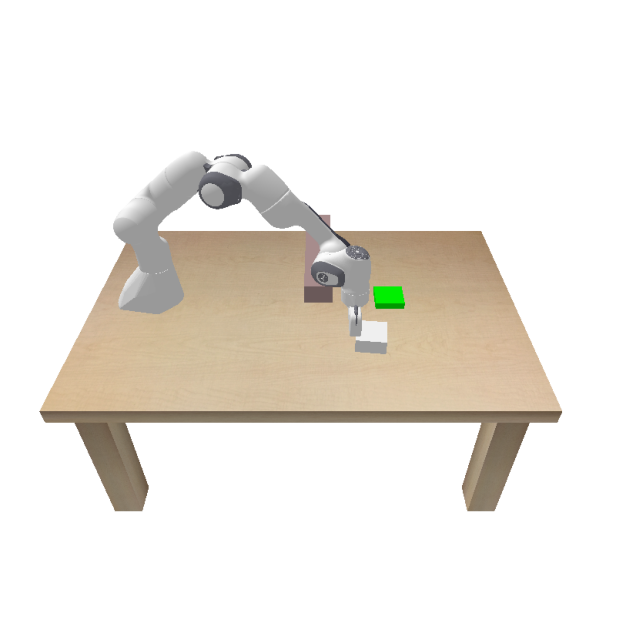

argv[0]=--opengl2
Step 0: Executing action...
Step 1: Executing action...
Step 2: Executing action...
Step 3: Executing action...
Step 4: Executing action...
Step 5: Executing action...
Step 6: Executing action...
Step 7: Executing action...
Step 8: Executing action...
Step 9: Executing action...
Step 10: Executing action...
Step 11: Executing action...
Step 12: Executing action...
Step 13: Executing action...
Step 14: Executing action...
Step 15: Executing action...
Step 16: Executing action...
Step 17: Executing action...
Step 18: Executing action...
Step 19: Executing action...
Step 20: Executing action...
Step 21: Executing action...
Step 22: Executing action...
Step 23: Executing action...
Step 24: Executing action...
Step 25: Executing action...
Step 26: Executing action...
Step 27: Executing action...
Step 28: Executing action...
Step 29: Executing action...
Step 30: Executing action...
Step 31: Executing action...
Step 32: Executing action...
Step 33: Executing action...
Step 3

In [130]:
%matplotlib inline
obstacle_policy_model = PPO.load("obstacle_pushing_object_pose")

# Create the visualizer
fig = plt.figure(figsize=(8,8))
hfig = display(fig, display_id=True)
visualizer = NotebookVisualizer(fig=fig, hfig=hfig)
env = PandaPushingEnv(state_space='object_pose',
                                reward_function=pushing_with_obstacles_reward_function_object_pose_space,
                                include_obstacle=True,
                                visualizer=visualizer,
                                render_non_push_motions=False,
                                render_every_n_steps=5,
                                camera_heigh=800,
                                camera_width=800)
num_steps = 40

states, rewards, goal_reached = execute_policy(env, obstacle_policy_model, num_steps)

print(f'GOAL REACHED: {goal_reached}')

plt.close(fig)